## Multiplayer Proxy Failure _ Data analysis


In [1]:

import module
import numpy as np
import csv
from joblib import Parallel, delayed
from itertools import product
import pandas as pd
import matplotlib 

In [2]:
# use pandas to read filtered data
df = pd.read_csv('data_file_all__done.csv')
#df = pd.read_csv('data_file_dump_baby.csv')
pd.set_option('display.max_columns', None)

df["goal_improvement"] = df["maxed_goal_value"] - df["goal_base"]
df["delta_opti_goal"] = df["optimal_goal_value"] - df["goal_base"]
df["correlation_diff"] = df['correlation_on_max_proxy'] -  df['correlation_base'] 
df["proxy_improvement"] = df["maxed_proxy_value"] - df["proxy_base"]
df["D"] = df['goal_discard'] - df["proxy_discard"]
df['E'] = df["avg_number_of_edges"]
df['S'] = df["spectral_radius"]
df['N'] = df["n"]

sub_df = df[df["correlation_diff"].notna()]
sub_df.describe()

,n,trials,proxy_discard,goal_discard,measure_time,spectral_radius,alpha,avg_number_of_edges,correlation_std,maxed_goal_value,goal_base,maxed_proxy_value,proxy_base,correlation_on_max_proxy,correlation_base,optimal_goal_value,optimal_proxy_value,correlation_on_optimal_proxy,goal_improvement,delta_opti_goal,correlation_diff,proxy_improvement,D,E,S,N
count,8045.000000,8045.0,8045.0,8045.000000,8045.0,8045.000000,8.045000e+03,8045.000000,8045.000000,8045.000000,8.045000e+03,8.045000e+03,8045.000000,8045.000000,8045.000000,8045.000000,8.045000e+03,7819.000000,8045.000000,8045.000000,8045.000000,8045.000000,8045.000000,8045.000000,8045.000000,8045.000000
mean,479.933375,50.0,50.0,225.338720,50.0,1.874021,1.000000e-01,4.488999,0.385037,0.182442,-5.083647e-04,2.829959e-01,0.000159,0.578501,0.787086,0.095236,2.515086e-01,0.336795,0.182950,0.095744,-0.208585,0.282836,175.338720,4.488999,1.874021,479.933375
std,345.917320,0.0,0.0,147.903971,0.0,0.740644,1.421174e-14,2.567252,0.134496,0.199233,4.314260e-02,2.137615e-01,0.069573,0.400847,0.180178,0.214196,1.993012e-01,0.518563,0.204346,0.217983,0.358589,0.224349,147.903971,2.567252,0.740644,345.917320
min,120.000000,50.0,50.0,50.000000,50.0,1.000000,1.000000e-01,1.000000,0.095791,-0.327074,-2.794677e-01,1.177048e-10,-0.399668,-1.000000,0.120008,-0.938542,1.413149e-15,-1.000000,-0.350424,-1.038448,-2.000000,-0.016539,0.000000,1.000000,1.000000,120.000000
25%,256.000000,50.0,50.0,150.000000,50.0,1.000000,1.000000e-01,2.000000,0.288607,0.009868,-1.355964e-02,6.027063e-02,-0.024598,0.396547,0.679425,-0.001263,4.279916e-02,-0.046678,0.009439,-0.002204,-0.260105,0.059471,100.000000,2.000000,1.000000,256.000000
50%,512.000000,50.0,50.0,250.000000,50.0,1.500000,1.000000e-01,4.000000,0.379111,0.131611,-1.758752e-08,2.934191e-01,0.000000,0.690218,0.837039,0.020595,2.544751e-01,0.273812,0.129973,0.020933,-0.105748,0.274680,200.000000,4.000000,1.500000,512.000000
75%,1024.000000,50.0,50.0,450.000000,50.0,3.000000,1.000000e-01,8.000000,0.472449,0.303332,1.311923e-02,4.298647e-01,0.026789,0.862931,0.930420,0.206314,3.913510e-01,1.000000,0.301804,0.205140,-0.023053,0.438231,400.000000,8.000000,3.000000,1024.000000
max,1024.000000,50.0,50.0,450.000000,50.0,3.000000,1.000000e-01,8.000000,0.883089,0.998696,3.040012e-01,9.985147e-01,0.431572,1.000000,1.000000,0.998690,9.936268e-01,1.000000,1.175657,1.096200,0.262728,1.309222,400.000000,8.000000,3.000000,1024.000000


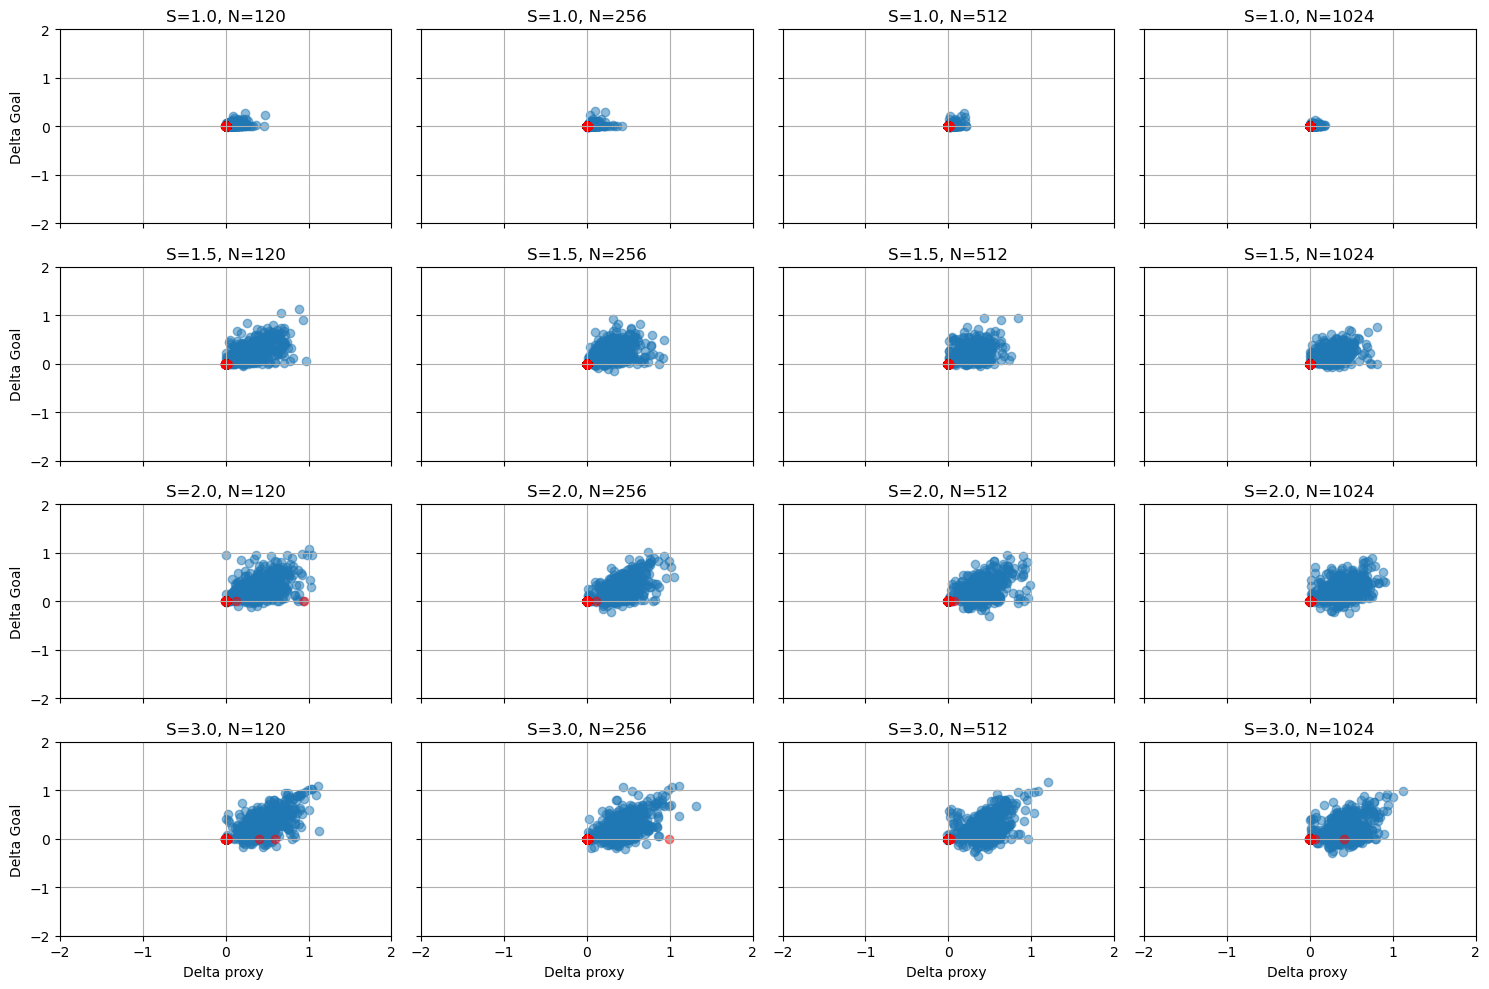

In [3]:
from scipy.optimize import curve_fit
import json
import numpy as np
import matplotlib.pyplot as plt
from itertools import product


def plot_deltagoal_vs_deltaproxcorrelation_along(df, param1, param2):
    ''' find all possible values of param1 and param2 in the dataframe df
        and plot the delta goal vs delta proxy for each combination of param1 and param2
    '''
    param1_values = df[param1].unique()
    param2_values = df[param2].unique()
    param_combinations = list(product(param1_values, param2_values))
    fig, axes = plt.subplots(len(param1_values), len(param2_values), figsize=(15, 10), sharex=True, sharey=True)
    for (p1, p2) in param_combinations:
        sub_df = df[(df[param1] == p1) & (df[param2] == p2)]
        xi = param1_values.tolist().index(p1)
        yi = param2_values.tolist().index(p2)
        ax = axes[xi, yi]


        ax.scatter(sub_df["proxy_improvement"],sub_df["goal_improvement"], alpha = 0.5)
        na_df = sub_df[sub_df["correlation_diff"].isna()]
        ax.scatter(na_df["goal_improvement"],[0]*len(na_df), color = "r", alpha = 0.5)
        ax.set_title(f'{param1}={p1}, {param2}={p2}')
        if param2_values.tolist().index(p2) == 0:
            ax.set_ylabel('Delta Goal')
        if param1_values.tolist().index(p1) == len(param1_values)-1:
            ax.set_xlabel('Delta proxy ')

        ax.grid()
        ax.set_xlim(-2, 2)
        ax.set_ylim(-2, 2)
    plt.tight_layout()
    plt.show()
    
plot_deltagoal_vs_deltaproxcorrelation_along(df, 'S', 'N')


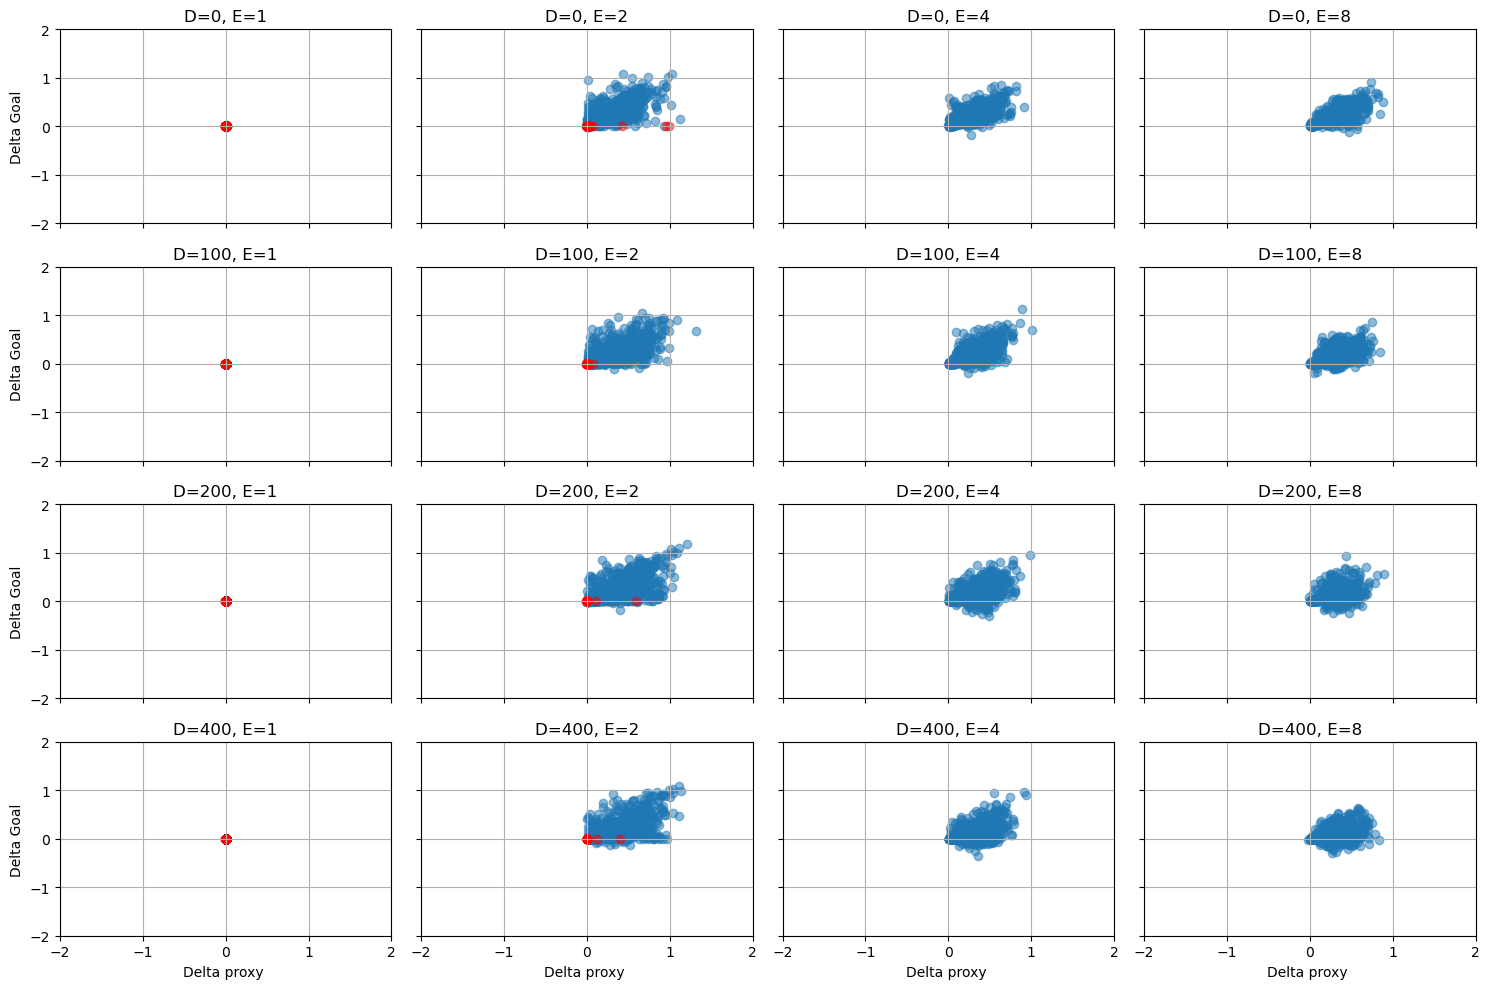

In [4]:
plot_deltagoal_vs_deltaproxcorrelation_along(df, "D", 'E')


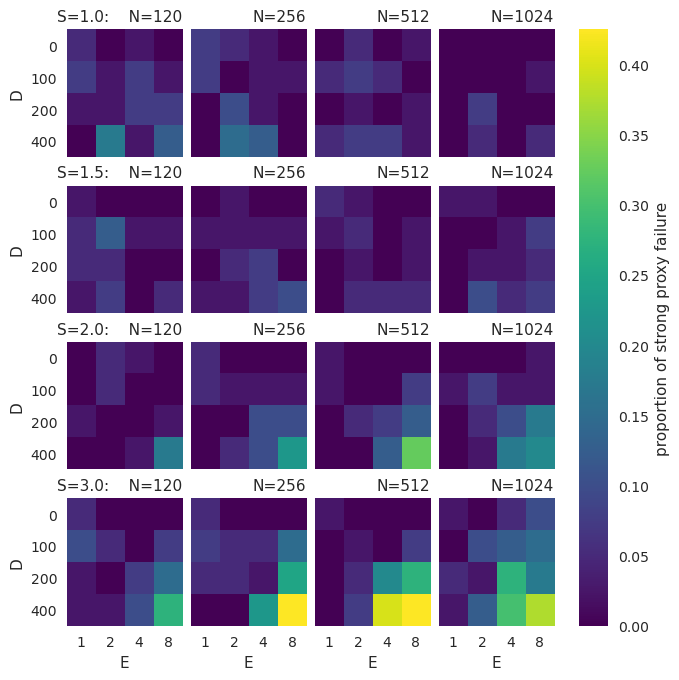

In [79]:
def plot_4params(df, param1, param2, param3, param4, weak = False):
    ''' find all possible values of param1 and param2 in the dataframe df
        then for each combination of param1 and param2, make a scatter plot along the other two parameters
        and color the points according to param_for_color
    '''
    param1_values = df[param1].unique()
    param2_values = df[param2].unique()
    param3_values = df[param3].unique() 
    param4_values = df[param4].unique()
    cm = 1/2.54
    param_combinations = list(product(param1_values, param2_values))
    fig, axes = plt.subplots(len(param1_values), len(param2_values), figsize=(17*cm, 17*cm), sharex=True, sharey=True, layout='compressed')
    #search for the maximum and minimum of param_for_color
    param_range = range(len(param_combinations))
    Ms = [np.zeros((len(param3_values), len(param4_values))) for k in param_range]

    
    for k in param_range:
        (p1, p2 )= param_combinations[param_range[k]]
        sub_df = df[(df[param1] == p1) & (df[param2] == p2)]
        xi = param1_values.tolist().index(p1)
        yi = param2_values.tolist().index(p2)
        ax = axes[xi, yi]


        # create all combinations of param3 and param4
        
        param3_values = sub_df[param3].unique() # reverse the order
        param4_values = sub_df[param4].unique()
        param3_4_combinations = list(product(param3_values, param4_values))

        for (p3, p4) in param3_4_combinations:
            subsub_df = sub_df[(sub_df[param3] == p3) & (sub_df[param4] == p4)]
            
            prop_failure = len(subsub_df[subsub_df["goal_improvement"] < -0.001]) / len(subsub_df) 
            if weak:
                subsub_df = subsub_df[subsub_df.notna()]
                prop_failure = len(subsub_df[(subsub_df["correlation_diff"] < 0) ]) / len(subsub_df)

            Ms[k][param3_values.tolist().index(p3), param4_values.tolist().index(p4)] = prop_failure

        # make a colormap of M
        cmax = max([np.max(Ms[k]) for k in range(len(param_combinations))])
        cmin = min([np.min(Ms[k]) for k in range(len(param_combinations))])
    for k in param_range:
        (p1, p2 )= param_combinations[param_range[k]]
        xi = param1_values.tolist().index(p1)
        yi = param2_values.tolist().index(p2)
        ax = axes[xi, yi]
        ax.grid(False)
        c = ax.imshow(Ms[k], origin='lower', vmin=cmin, vmax=cmax, cmap='viridis', aspect='auto')

        #ax.scatter(grouped[param3], grouped[param4], alpha = 0.7, color = plt.cm.viridis((grouped[param_for_color] - min_color) / (max_color - min_color)))
        if param2_values.tolist().index(p2) == 0:
            ax.set_ylabel(param3)
            ax.set_yticks([0,1,2,3],param3_values) 
            ax.set_title(f'{param1}={p1}:    {param2}={p2}', fontsize = 11, loc='right')
        else:
            ax.set_title(f'{param2}={p2}', fontsize = 11, loc='right')
        if param1_values.tolist().index(p1) == len(param1_values)-1:
            ax.set_xlabel(param4)
            ax.set_xticks([0,1,2,3],param4_values)
        ax.invert_yaxis()
        




    # add a common colorbar between the maximum and minimum of param_for_color
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=cmin, vmax=cmax))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='vertical')
    if weak:
        cbar.set_label("proportion of weak proxy failure", fontsize = 11)
    else:
        cbar.set_label("proportion of strong proxy failure", fontsize = 11)
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    plt.savefig("test.pdf")
    plt.show()
plot_4params(df, 'S', 'N', 'D', 'E', False)


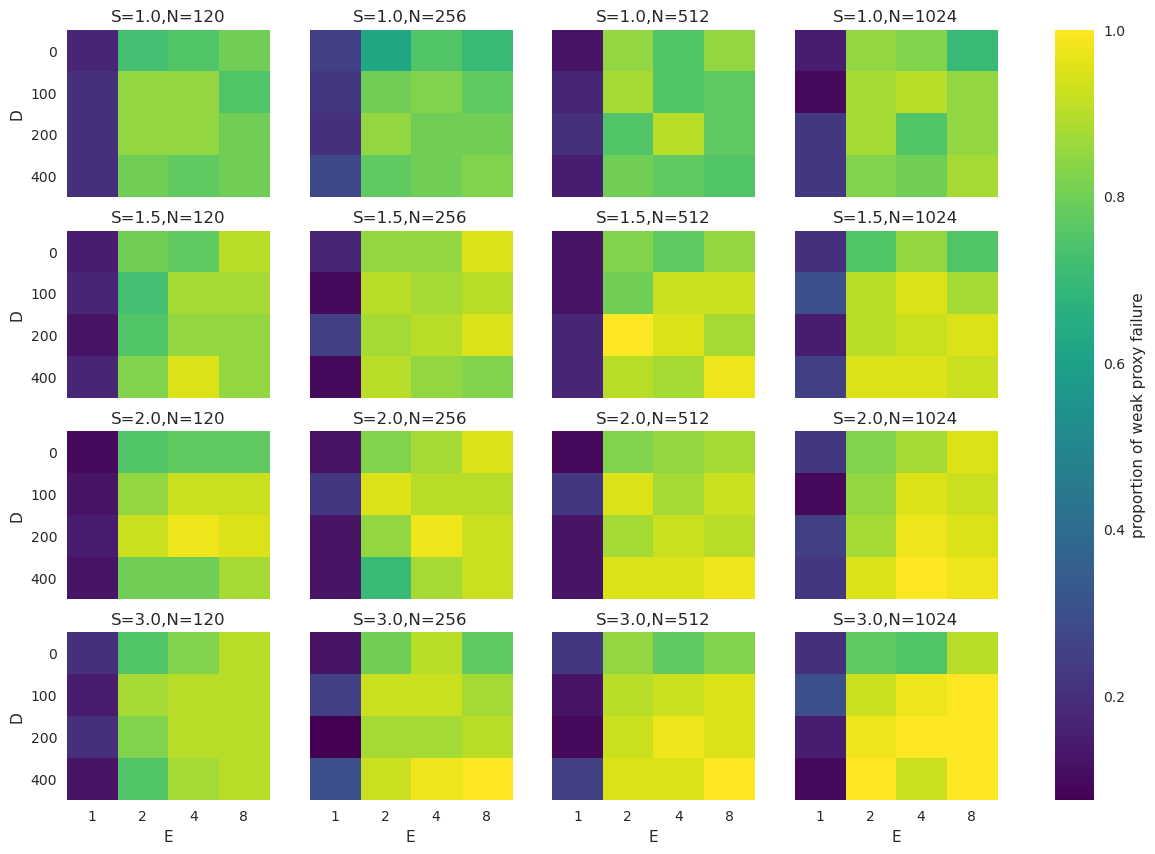

In [17]:
plot_4params(df, 'S', 'N', 'D', 'E', True)

In [7]:
from sklearn.cross_decomposition import PLSRegression

X = [[0., 0., 1.], [1.,0.,9.], [2.,0.,62], [1.,1.,119]]

y = [0.1, 0.9, 6.2, 11.9]

pls2 = PLSRegression(n_components=2)

pls2.fit(X, y)
PLSRegression()

y_pred = pls2.predict(X)
pls2.coef_
pls2.transform(X)

array([[-1.31878811,  0.11072015],
       [-0.81608175, -0.18799199],
       [ 0.27420347,  0.0952922 ],
       [ 1.8606664 , -0.01802035]])

In [8]:
# create a new data base that groups collumns based of the parameters D E S N
unic = []
weak = False
param_list = ['D',"E","S","N"]
for k in param_list:
    unic.append( df[k].unique())

param_combinations = list(product(unic[0],unic[1],unic[2],unic[3] ))

Y = []
for k in range(len(param_combinations)):
    (p0,p1, p2,p3)= param_combinations[k]
    subsub_df = df[(df[param_list[0]] == p0) & (df[param_list[1]] == p1) &(df[param_list[2]] == p2) &(df[param_list[3]] == p3)]
    
    prop_failure = len(subsub_df[subsub_df["goal_improvement"] < -0.001]) / len(subsub_df) 
    if weak:
        subsub_df = subsub_df[subsub_df.notna()]
        prop_failure = len(subsub_df[(subsub_df["correlation_diff"] < 0) ]) / len(subsub_df)

    Y.append(prop_failure)

Y = np.asarray(Y)
Y = Y.reshape((-1,1))
Y_strong = Y

R² scores: [0.32252349375514267, 0.32252349375514267, 0.32252349375514255, 0.32252349375514255]


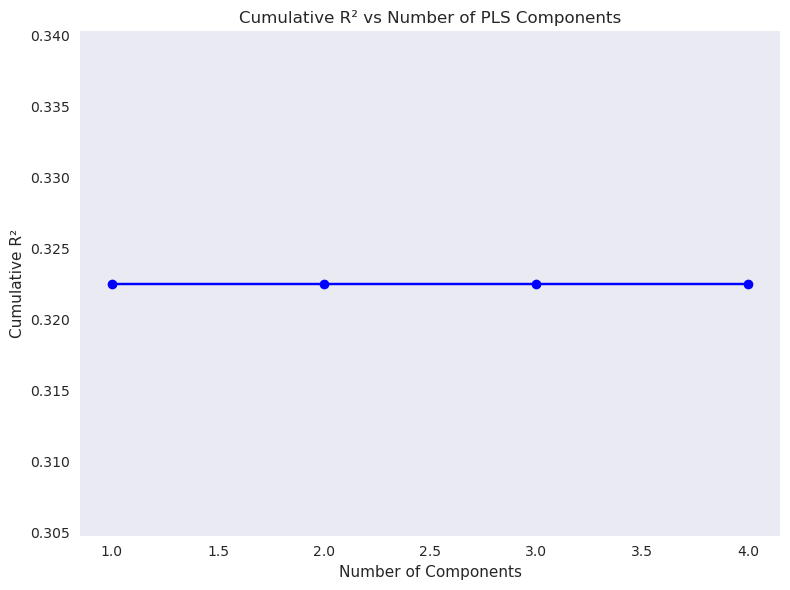

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
np.random.seed(42)


subsamples = 256 # number of subsamples to use
#X # = df[['n', 'S', 'D', 'E']].to_numpy()

# Standardize X and Y
X = param_combinations

subX = X[:subsamples]
subY = Y_strong[:subsamples]
scaler_X = StandardScaler()
scaler_Y = StandardScaler()
X_scaled = scaler_X.fit_transform(subX)
Y_scaled = scaler_Y.fit_transform(subY)

# Step 4 & 5: Fit PLSRegression with 1 to 10 components and compute R² scores
r2_scores = []
for n_comp in range(1, 5):
    pls = PLSRegression(n_components=n_comp)
    pls.fit(X_scaled, Y_scaled)
    Y_pred = pls.predict(X_scaled)
    r2 = r2_score(Y_scaled, Y_pred)
    r2_scores.append(r2)

# Step 6: Plot cumulative R² vs number of components
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(8, 6))
plt.plot(range(1, 5), r2_scores, marker='o', color='blue')
plt.title('Cumulative R² vs Number of PLS Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative R²')
plt.grid(False)
plt.tight_layout()
#plt.savefig('/mnt/data/plsr_r2_plot.png')
print("R² scores:", r2_scores)  # Print R² scores for reference




Predicted Y for new X: [[0.01880984]]


/tmp/ipykernel_10634/3077508912.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  M[k%16, k//16] = predicted_Y_all[k]


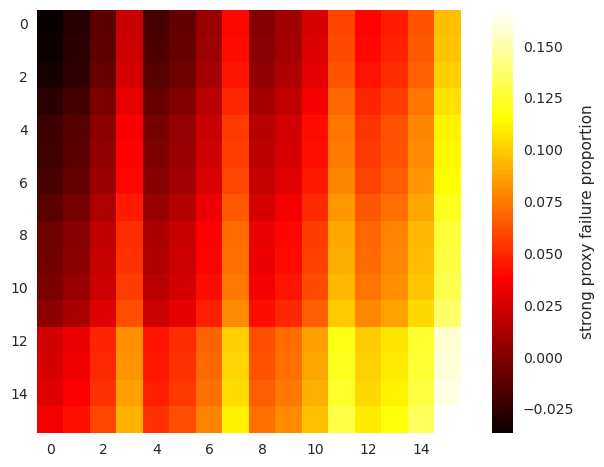

In [10]:

# use te PLS model to predict the Y value for a new X value
new_X = np.array([[16, 3.5, 2, 256]])
new_X_scaled = scaler_X.transform(new_X)
predicted_Y_scaled = pls.predict(new_X_scaled)
predicted_Y = scaler_Y.inverse_transform(predicted_Y_scaled)
print("Predicted Y for new X:", predicted_Y)

# predict for all values of X 
predicted_Y_all_scaled = pls.predict(X_scaled)
predicted_Y_all = scaler_Y.inverse_transform(predicted_Y_all_scaled)

M = np.zeros((16,16))
for k in range(len(predicted_Y_all)):
    M[k%16, k//16] = predicted_Y_all[k]

# compare predicted_Y_all with Y
import matplotlib.pyplot as plt
plt.grid(False)
plt.imshow(M, cmap='hot', interpolation='nearest')
plt.colorbar(label='strong proxy failure proportion')
plt.show()


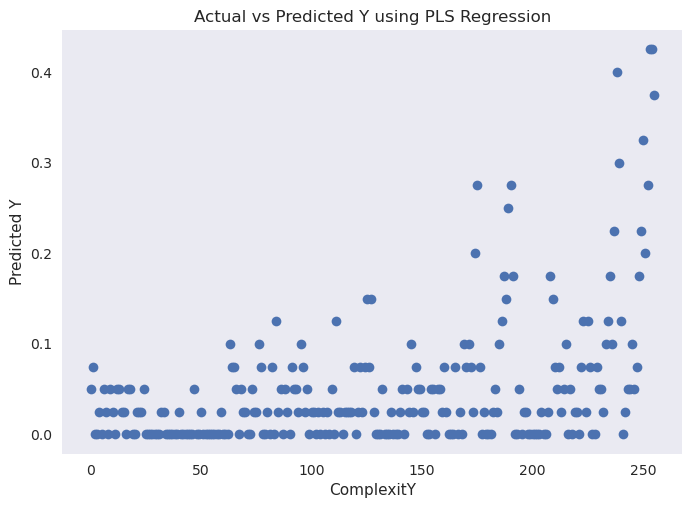

In [11]:
a = Y_strong.flatten()

plt.plot([k for k in range(256)],a, 'o')
plt.xlabel('ComplexitY')
plt.ylabel('Predicted Y')
plt.title('Actual vs Predicted Y using PLS Regression')
plt.grid()
plt.show()

In [64]:
# create a new data base that groups collumns based of the parameters D E S N
unic = []
weak = False
txttitle = "Strong"
if weak :
    txttitle = "Weak"

param_list = ['D',"E","S","N"]
for k in param_list:
    unic.append( df[k].unique())

param_combinations = list(product(unic[0],unic[1],unic[2],unic[3] ))

Ystronk = [[] for k in range(17)]
Yweak = [[] for k in range(17)]
for k in range(len(param_combinations)):
    (p0,p1, p2,p3)= param_combinations[k]
    complexity_class = sum([1+unic[i].tolist().index(param_combinations[k][i]) for i in range(4)])
    subsub_df = df[(df[param_list[0]] == p0) & (df[param_list[1]] == p1) &(df[param_list[2]] == p2) &(df[param_list[3]] == p3)]
    
    prop_failure = len(subsub_df[subsub_df["goal_improvement"] < -0.001]) / len(subsub_df) 

    subsub_df = subsub_df[subsub_df.notna()]
    prop_failur_weak = len(subsub_df[(subsub_df["correlation_diff"] < 0) ]) / len(subsub_df)

    Ystronk[complexity_class].append(prop_failure)
    Yweak[complexity_class].append(prop_failur_weak)

Y2stronk =  [np.mean(Ystronk[k]) for k in range(len(Ystronk))]
Y2stronk = Y2stronk[4:] # ignore the first four values
std2stronk = [np.sqrt((Y2stronk[k]) * (1 - (Y2stronk[k])) / len(Y2stronk))  for k in range(len(Y2stronk))]

Y2weak =  [np.mean(Yweak[k]) for k in range(len(Yweak))]
Y2weak = Y2weak[4:] # ignore the first four values
std2weak = [np.sqrt((Y2weak[k]) * (1 - (Y2weak[k])) / len(Y2weak))  for k in range(len(Y2weak))]



/home/paulbanse/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/paulbanse/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


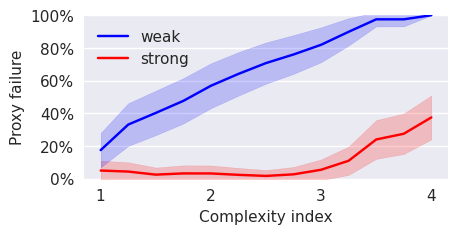

In [78]:
from IPython.display import SVG, display
import io

a = Y_strong.flatten()
X_scaled01 = (X_scaled - X_scaled.min(axis=0)) / (X_scaled.max(axis=0) - X_scaled.min(axis=0))

Xes = [k/4 for k in range(4,17)]
Xlab = [str(int(k/4))*(int(k/4)== k/4)+'' for k in range(4,17)]

cm = 1/2.54
fig, ax = plt.subplots(figsize=(17*2/3*cm, 17/3*cm),layout='compressed')
ax.yaxis.grid(True)
ax.xaxis.grid(False)
plt.fill_between(Xes, np.array(Y2stronk)-np.array(std2stronk), np.array(Y2stronk)+np.array(std2stronk), color='r', alpha=0.2)
plt.fill_between(Xes, np.array(Y2weak)-np.array(std2weak), np.array(Y2weak)+np.array(std2weak), color='b', alpha=0.2)
plt.plot(Xes, Y2weak, '-', color='b', label = 'weak')
plt.plot(Xes, Y2stronk, '-', color='r', label="strong")
plt.xlabel('Complexity index', fontsize = 11)
plt.ylabel('Proxy failure', fontsize = 11)
plt.ylim(0,1)
plt.yticks([0,0.2,0.4,0.6,0.8,1], ['0%','20%','40%','60%','80%','100%'], fontsize = 11)
plt.xticks(Xes, labels = Xlab, fontsize = 11)

plt.legend(fontsize = 11)
plt.savefig("test.svg")
plt.show()




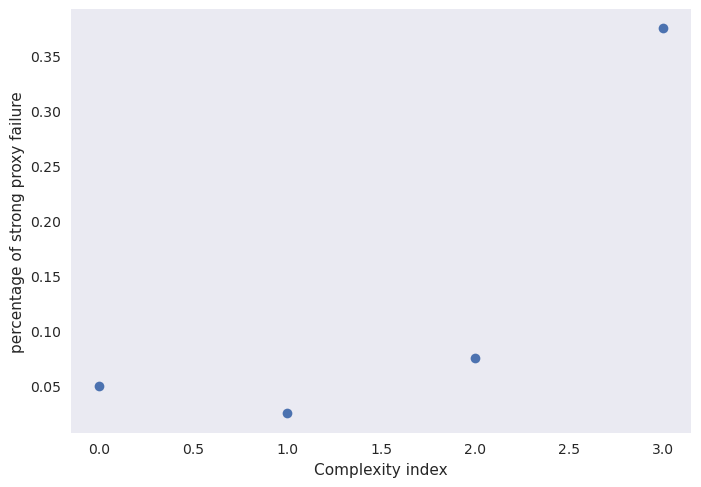

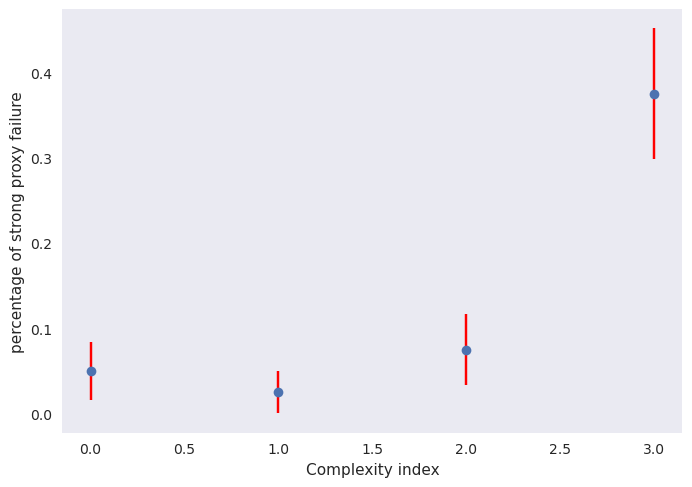

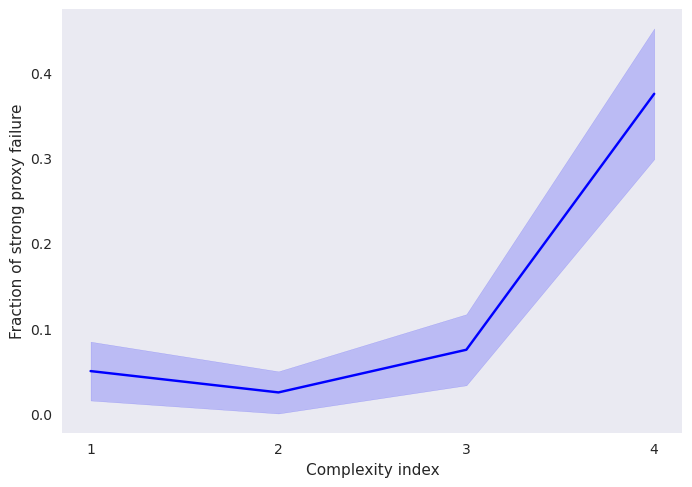

In [14]:
# create a new data base that groups collumns based of the parameters D E S N
unic = []
weak = False
param_list = ['D',"E","S","N"]
for k in param_list:
    unic.append( df[k].unique())

param_combinations = list(product(unic[0],unic[1],unic[2],unic[3] ))

Y = [[] for k in range(len(param_combinations))]

Y3 =  []

for k in range(4):
    subsub_df = df[(df[param_list[0]] == unic[0][k]) & (df[param_list[1]] == unic[1][k]) &(df[param_list[2]] == unic[2][k]) &(df[param_list[3]] == unic[3][k])]
    
    prop_failure = len(subsub_df[subsub_df["goal_improvement"] < -0.001]) / len(subsub_df) 
    if weak:
        subsub_df = subsub_df[subsub_df.notna()]
        prop_failure = len(subsub_df[(subsub_df["correlation_diff"] < 0) ]) / len(subsub_df)

    Y3.append(prop_failure)

plt.plot( Y3, 'o')
plt.xlabel('Complexity index')
plt.ylabel('percentage of strong proxy failure')
plt.grid()
plt.show()

# compute 


import matplotlib.pyplot as plt
import numpy as np
means = [np.mean(Y3[k]) for k in range(len(Y3))]
stds = [np.sqrt((Y3[k]) * (1 - (Y3[k])) / 40)  for k in range(len(Y3))]
plt.errorbar([k for k in range(4)], means, yerr=stds, fmt='o', ecolor='r', capthick=2)
plt.xlabel('Complexity index')
plt.ylabel('percentage of strong proxy failure')
plt.grid()
plt.show()

# can you link the error bars into a area and the dots into a line  plot?
import matplotlib.pyplot as plt
import numpy as np
means = [np.mean(Y3[k]) for k in range(len(Y3))]
stds = [np.sqrt((Y3[k]) * (1 - (Y3[k])) / 40)  for k in range(len(Y3))]
plt.fill_between([k+1 for k in range(4)], np.array(means)-np.array(stds), np.array(means)+np.array(stds), color='b', alpha=0.2)
plt.plot([k+1 for k in range(4)], means, '-', color='b')
plt.xlabel('Complexity index')
plt.ylabel('Fraction of strong proxy failure')
plt.xticks([k+1 for k in range(4)])
plt.grid()
plt.show()


In [15]:
stds

[0.034460121880225555,
 0.024685522072664372,
 0.04164582812239421,
 0.07654655446197431]